In [1]:
from river.datasets import ImageSegments
from river.preprocessing import MinMaxScaler
from river.tree import HoeffdingTreeClassifier
from deep_river.classification import Classifier
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.manifold import TSNE

random.seed(0)

### Create Stream

In [2]:
stream_size = 10_000

x, y = list(zip(*ImageSegments()))
x = np.array(x)
y = np.array(y)

# Divide classes into two task specific sets
task_classes = [
    ["brickface", "window", "cement"],
    ["sky", "foliage", "path", "grass"],
]

# Divide all samples into their specific tasks
data_train = []
data_test = []
for classes_t in task_classes:
    x_t = np.concatenate([x[y == c] for c in classes_t])
    y_t = np.concatenate([330 * [c] for c in classes_t])
    x_train, x_test, y_train, y_test = train_test_split(
        x_t, y_t, test_size=0.25, stratify=y_t
    )
    x_train, y_train = resample(
        x_train, y_train, n_samples=int(stream_size / 2), stratify=y_train
    )
    data_train.append(list(zip(x_train, y_train)))
    data_test.append(list(zip(x_test, y_test)))

data_train = data_train[0] + data_train[1]

### Visualize Data

In [3]:
classnames = task_classes[0] + task_classes[1]
tsne = TSNE(init="pca", learning_rate="auto", n_jobs=-1)
x_array = np.array([list(x_i.values()) for x_i in x])
x_viz = tsne.fit_transform(x_array)

/Users/cedrickulbach/Documents/Projects/deep-river/.venv/lib/python3.10/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


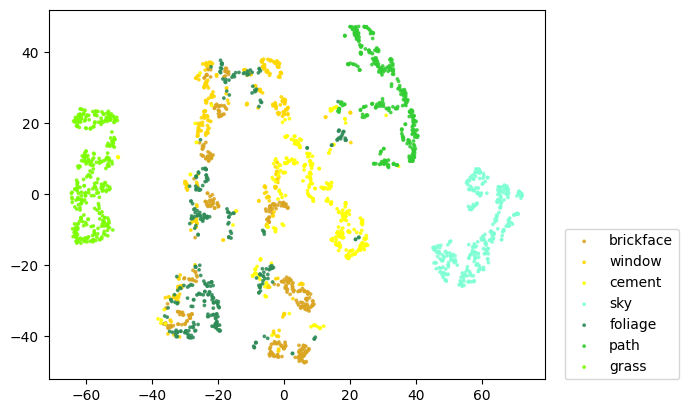

In [4]:
fig, ax = plt.subplots()
cm = [
    "goldenrod",
    "gold",
    "yellow",
    "aquamarine",
    "seagreen",
    "limegreen",
    "lawngreen",
]
for c_idx, x_c in enumerate([x_viz[y == c] for c in classnames]):
    scatter = ax.scatter(
        x_c[:, 0],
        x_c[:, 1],
        c=len(x_c) * [cm[c_idx]],
        s=3,
        alpha=0.8,
        label=classnames[c_idx],
    )

ax.legend(loc=(1.04, 0))

### Define evaluation procedure

In [5]:
# Define function to calculate accuracy on testing data for each task
def get_test_accuracy(model, data_test):
    results = []
    for data_test_i in data_test:
        ys = []
        y_preds = []
        for x_test, y_test in data_test_i:
            ys.append(y_test)
            y_preds.append(model.predict_one(x_test))
        accuracy = accuracy_score(ys, y_preds)
        results.append(accuracy)
    return results


# Define training and testing loop
def eval_separate_testing(model, data_train, data_test):
    scaler = MinMaxScaler()
    step = 0
    steps = []
    results = [[] for task in data_test]
    for x, y in tqdm(data_train):
        step += 1
        scaler.learn_one(x)
        x = scaler.transform_one(x)
        model.learn_one(x, y)

        if step % 100 == 0:
            test_accuracies = get_test_accuracy(model, data_test)
            for idx, accuracy in enumerate(test_accuracies):
                results[idx].append(accuracy)
            steps.append(step)
    return steps, results

## Evaluate Classifiers

In [6]:
# Evaluate a simple MLP classifier
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super(SimpleMLP, self).__init__()
        self.dense0 = nn.Linear(n_features, 5)
        self.nonlin = nn.ReLU()
        self.dense1 = nn.Linear(5, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.nonlin(self.dense1(X))
        X = self.softmax(X)
        return X


mlp = Classifier(
    SimpleMLP(30),
    loss_fn="binary_cross_entropy_with_logits",
    optimizer_fn="sgd",
    lr=0.05,
    seed=42,
)
steps, results_mlp = eval_separate_testing(mlp, data_train, data_test)

  0%|                                                                                                                                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                                                                                                                                                 | 69/10000 [00:00<00:14, 685.95it/s]

  1%|███▊                                                                                                                                                                                                                                                                              | 138/10000 [00:00<00:17, 570.05it/s]

  2%|█████▍                                                                                                                                                                                                                                                                            | 200/10000 [00:00<00:17, 545.43it/s]

  3%|████████▏                                                                                                                                                                                                                                                                         | 300/10000 [00:00<00:15, 612.60it/s]

  4%|██████████▉                                                                                                                                                                                                                                                                       | 400/10000 [00:00<00:14, 652.04it/s]

  5%|█████████████▋                                                                                                                                                                                                                                                                    | 500/10000 [00:00<00:14, 677.48it/s]

  6%|████████████████▍                                                                                                                                                                                                                                                                 | 600/10000 [00:00<00:13, 697.60it/s]

  7%|███████████████████▏                                                                                                                                                                                                                                                              | 700/10000 [00:01<00:13, 706.66it/s]

  8%|█████████████████████▉                                                                                                                                                                                                                                                            | 800/10000 [00:01<00:12, 707.89it/s]

  9%|████████████████████████▋                                                                                                                                                                                                                                                         | 900/10000 [00:01<00:12, 710.96it/s]

 10%|███████████████████████████▎                                                                                                                                                                                                                                                     | 1000/10000 [00:01<00:12, 715.83it/s]

 11%|██████████████████████████████                                                                                                                                                                                                                                                   | 1100/10000 [00:01<00:12, 719.11it/s]

 12%|████████████████████████████████▊                                                                                                                                                                                                                                                | 1200/10000 [00:01<00:12, 714.52it/s]

 13%|███████████████████████████████████▍                                                                                                                                                                                                                                             | 1300/10000 [00:01<00:12, 720.39it/s]

 14%|██████████████████████████████████████▏                                                                                                                                                                                                                                          | 1400/10000 [00:02<00:11, 725.33it/s]

 15%|████████████████████████████████████████▉                                                                                                                                                                                                                                        | 1500/10000 [00:02<00:11, 729.43it/s]

 16%|███████████████████████████████████████████▋                                                                                                                                                                                                                                     | 1600/10000 [00:02<00:11, 724.98it/s]

 17%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 1700/10000 [00:02<00:11, 730.61it/s]

 18%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 1800/10000 [00:02<00:11, 731.66it/s]

 19%|███████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 1900/10000 [00:02<00:11, 731.59it/s]

 20%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 2000/10000 [00:02<00:11, 724.02it/s]

 21%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                       | 2100/10000 [00:02<00:10, 725.22it/s]

 22%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                     | 2200/10000 [00:03<00:10, 727.33it/s]

 23%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                  | 2300/10000 [00:03<00:10, 723.26it/s]

 24%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                               | 2400/10000 [00:03<00:10, 724.41it/s]

 25%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 2500/10000 [00:03<00:10, 724.99it/s]

 26%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 2600/10000 [00:03<00:10, 718.48it/s]

 27%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 2700/10000 [00:03<00:10, 715.51it/s]

 28%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 2800/10000 [00:03<00:10, 711.16it/s]

 29%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 2900/10000 [00:04<00:10, 707.47it/s]

 30%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 3000/10000 [00:04<00:09, 711.05it/s]

 31%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                            | 3100/10000 [00:04<00:09, 720.73it/s]

 32%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 3200/10000 [00:04<00:09, 726.98it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 3300/10000 [00:04<00:09, 725.48it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 3400/10000 [00:04<00:09, 723.70it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 3500/10000 [00:04<00:08, 723.37it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 3600/10000 [00:05<00:08, 726.41it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 3700/10000 [00:05<00:08, 725.35it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 3800/10000 [00:05<00:08, 725.04it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 3900/10000 [00:05<00:08, 726.09it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4000/10000 [00:05<00:08, 727.37it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4100/10000 [00:05<00:08, 718.48it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 4200/10000 [00:05<00:08, 718.17it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 4300/10000 [00:06<00:07, 714.67it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 4400/10000 [00:06<00:07, 714.03it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 4500/10000 [00:06<00:07, 715.29it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 4600/10000 [00:06<00:07, 717.06it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 4700/10000 [00:06<00:07, 718.95it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 4800/10000 [00:06<00:07, 717.98it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 4900/10000 [00:06<00:07, 721.21it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 5000/10000 [00:07<00:06, 718.23it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 5100/10000 [00:07<00:06, 720.99it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 5200/10000 [00:07<00:06, 727.76it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 5300/10000 [00:07<00:06, 733.60it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 5400/10000 [00:07<00:06, 730.01it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 5500/10000 [00:07<00:06, 728.19it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 5600/10000 [00:07<00:06, 728.66it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 5700/10000 [00:07<00:05, 734.48it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 5800/10000 [00:08<00:05, 736.69it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 5900/10000 [00:08<00:05, 734.05it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 6000/10000 [00:08<00:05, 726.54it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 6100/10000 [00:08<00:05, 729.96it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 6200/10000 [00:08<00:05, 727.93it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 6300/10000 [00:08<00:05, 725.29it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 6400/10000 [00:08<00:04, 720.41it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 6500/10000 [00:09<00:04, 716.23it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 6600/10000 [00:09<00:04, 714.90it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 6700/10000 [00:09<00:04, 719.91it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 6800/10000 [00:09<00:04, 711.00it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 6900/10000 [00:09<00:04, 714.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 7000/10000 [00:09<00:04, 713.78it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 7100/10000 [00:09<00:04, 715.64it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 7200/10000 [00:10<00:03, 720.31it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 7300/10000 [00:10<00:03, 720.78it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 7400/10000 [00:10<00:03, 724.48it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 7500/10000 [00:10<00:03, 731.97it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 7600/10000 [00:10<00:03, 733.21it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 7700/10000 [00:10<00:03, 728.36it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 7800/10000 [00:10<00:03, 725.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 7900/10000 [00:11<00:02, 730.16it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 8000/10000 [00:11<00:02, 730.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 8100/10000 [00:11<00:02, 726.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 8200/10000 [00:11<00:02, 729.65it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 8300/10000 [00:11<00:02, 731.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 8400/10000 [00:11<00:02, 728.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 8500/10000 [00:11<00:02, 726.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8600/10000 [00:11<00:01, 726.78it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8700/10000 [00:12<00:01, 722.58it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 8800/10000 [00:12<00:01, 722.56it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8900/10000 [00:12<00:01, 729.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 9000/10000 [00:12<00:01, 730.73it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 9100/10000 [00:12<00:01, 724.52it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9200/10000 [00:12<00:01, 727.33it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 9300/10000 [00:12<00:00, 732.37it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 9400/10000 [00:13<00:00, 724.89it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9500/10000 [00:13<00:00, 724.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9600/10000 [00:13<00:00, 725.36it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9700/10000 [00:13<00:00, 734.79it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9800/10000 [00:13<00:00, 732.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9900/10000 [00:13<00:00, 723.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 725.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 719.72it/s]

In [7]:
# Evaluate a Hoeffding Tree classifier
tree = HoeffdingTreeClassifier(tau=0.05)
steps, results_tree = eval_separate_testing(tree, data_train, data_test)

  0%|                                                                                                                                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]

  2%|█████▍                                                                                                                                                                                                                                                                           | 200/10000 [00:00<00:06, 1401.48it/s]

  4%|██████████▉                                                                                                                                                                                                                                                                      | 400/10000 [00:00<00:06, 1413.79it/s]

  6%|████████████████▍                                                                                                                                                                                                                                                                | 600/10000 [00:00<00:06, 1417.47it/s]

  8%|█████████████████████▊                                                                                                                                                                                                                                                           | 800/10000 [00:00<00:06, 1408.06it/s]

 10%|███████████████████████████▏                                                                                                                                                                                                                                                    | 1000/10000 [00:00<00:06, 1410.37it/s]

 12%|████████████████████████████████▋                                                                                                                                                                                                                                               | 1200/10000 [00:00<00:06, 1426.35it/s]

 14%|██████████████████████████████████████                                                                                                                                                                                                                                          | 1400/10000 [00:00<00:05, 1449.83it/s]

 16%|███████████████████████████████████████████▌                                                                                                                                                                                                                                    | 1600/10000 [00:01<00:05, 1470.42it/s]

 18%|████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 1800/10000 [00:01<00:05, 1461.60it/s]

 20%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 2000/10000 [00:01<00:05, 1465.54it/s]

 22%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 2200/10000 [00:01<00:05, 1467.96it/s]

 24%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                              | 2400/10000 [00:01<00:05, 1458.74it/s]

 26%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 2600/10000 [00:01<00:05, 1438.14it/s]

 28%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                   | 2800/10000 [00:01<00:05, 1439.49it/s]

 30%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                              | 3000/10000 [00:02<00:04, 1455.77it/s]

 32%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                         | 3200/10000 [00:02<00:04, 1460.67it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 3400/10000 [00:02<00:04, 1459.35it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 3600/10000 [00:02<00:04, 1462.91it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 3800/10000 [00:02<00:04, 1474.20it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4000/10000 [00:02<00:04, 1471.10it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 4200/10000 [00:02<00:03, 1474.92it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 4400/10000 [00:03<00:03, 1481.42it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 4600/10000 [00:03<00:03, 1482.57it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 4800/10000 [00:03<00:03, 1471.34it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 5000/10000 [00:03<00:03, 1473.30it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 5148/10000 [00:03<00:03, 1310.80it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 5281/10000 [00:03<00:04, 1171.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 5400/10000 [00:04<00:05, 852.98it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 5500/10000 [00:04<00:05, 806.85it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 5600/10000 [00:04<00:05, 774.61it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 5700/10000 [00:04<00:05, 755.04it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 5800/10000 [00:04<00:05, 737.85it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 5900/10000 [00:04<00:05, 727.15it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 6000/10000 [00:04<00:05, 717.58it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 6100/10000 [00:05<00:05, 722.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 6200/10000 [00:05<00:05, 715.20it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 6300/10000 [00:05<00:05, 714.08it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 6400/10000 [00:05<00:05, 709.24it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 6500/10000 [00:05<00:04, 712.84it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 6600/10000 [00:05<00:04, 709.04it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 6700/10000 [00:05<00:04, 704.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 6800/10000 [00:06<00:04, 691.27it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 6900/10000 [00:06<00:04, 691.39it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 7000/10000 [00:06<00:04, 689.06it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 7100/10000 [00:06<00:04, 695.43it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 7200/10000 [00:06<00:04, 699.39it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 7300/10000 [00:06<00:03, 703.98it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 7400/10000 [00:06<00:03, 697.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 7500/10000 [00:07<00:03, 704.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 7600/10000 [00:07<00:03, 704.23it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 7700/10000 [00:07<00:03, 709.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 7800/10000 [00:07<00:03, 709.48it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 7900/10000 [00:07<00:02, 713.03it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 8000/10000 [00:07<00:02, 710.40it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 8100/10000 [00:07<00:02, 704.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 8200/10000 [00:07<00:02, 699.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 8300/10000 [00:08<00:02, 696.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 8400/10000 [00:08<00:02, 695.14it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 8500/10000 [00:08<00:02, 691.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8600/10000 [00:08<00:02, 690.11it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8700/10000 [00:08<00:01, 688.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 8800/10000 [00:08<00:01, 685.43it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8900/10000 [00:09<00:01, 695.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 9000/10000 [00:09<00:01, 699.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 9100/10000 [00:09<00:01, 703.52it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9200/10000 [00:09<00:01, 701.34it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 9300/10000 [00:09<00:00, 708.38it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 9400/10000 [00:09<00:00, 706.90it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9500/10000 [00:09<00:00, 702.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9600/10000 [00:10<00:00, 697.37it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9700/10000 [00:10<00:00, 703.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9800/10000 [00:10<00:00, 699.77it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9900/10000 [00:10<00:00, 706.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 705.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 945.89it/s]

### Visualize Accuracy over Timesteps

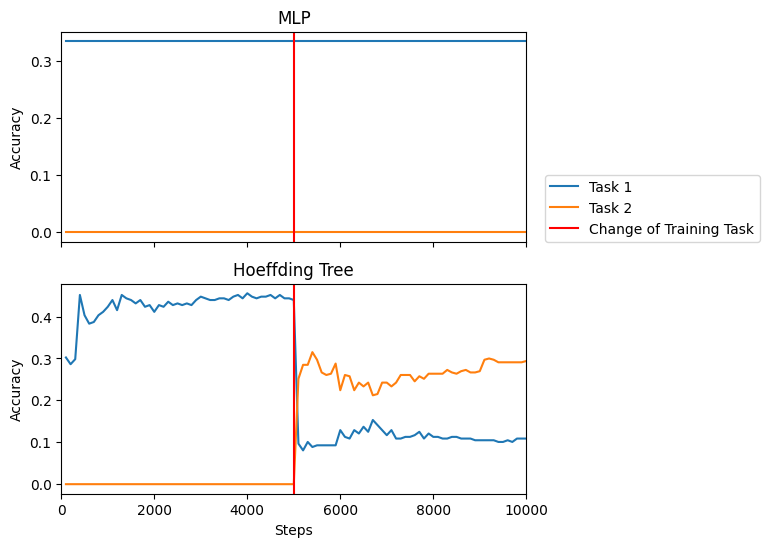

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
results = {"MLP": results_mlp, "Hoeffding Tree": results_tree}
for model_idx, (model_name, model_results) in enumerate(results.items()):
    ax = axs[model_idx]
    ax.plot(steps, model_results[0], label="Task 1")
    ax.plot(steps, model_results[1], label="Task 2")
    ax.axvline(5000, c="red", label="Change of Training Task")
    ax.set_ylabel("Accuracy")
    ax.set_title(model_name)
axs[-1].set_xlabel("Steps")
axs[-1].set_xlim(0, 10000)
axs[0].legend(loc=(1.04, 0))